### Experiment :
### Objectives

1. 
2. 
3. 

### Observations

1. 
2. 
3. 

### Solutions and further investigation

1. 
2. 
3. 

### Load Modeules and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,train_test_split
from keras import layers
from sklearn import metrics
from keras import regularizers
from keras import models,optimizers
from keras.models import Sequential
from tensorflow.python.keras.optimizer_v2.adam import Adam
from keras.layers import Dense,Input,SpatialDropout1D,Dropout,Flatten, SimpleRNN,LSTM,RNN,GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import re
import gensim
pd.set_option('display.max_colwidth', 1000)
# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills
import sinhala_stemmer

In [2]:
import neptune
from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report,log_confusion_matrix,log_prediction_distribution
from neptunecontrib.api import log_table
import os
from dotenv import load_dotenv

load_dotenv()
NEPTUNE_PROJECT= os.getenv('NEPTUNE_PROJECT')
NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
neptune.init(project_qualified_name= NEPTUNE_PROJECT,api_token=NEPTUNE_API_TOKEN) 
             

Project(codekcg23/Research-Experiments)

In [3]:
# load datasets - no preprocessing
path = '../Datasets/processed/no_stemming/'
df_A = pd.read_csv(path+'df_A.csv')     

In [4]:
# remove NaN entries in dataset
df_A.drop(index =[610,3070],inplace=True)

### Embedding

In [5]:
def load_emb_model(emb_model):
    from gensim.models import word2vec
    import gensim.models as FastText
    from gensim.test.utils import datapath
    
    if emb_model == "w2v_skipgram":
        model = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/word2vec/word2vec_300.w2v")
    elif emb_model == "w2v_cbow":
        model = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/CBOW-word2vec/cbow_300.w2v")
    elif emb_model == "fasttext":
        #FastText.load_fasttext_format("../../../corpus/analyzed/saved_models/wiki.si.bin")
        model = FastText.fasttext.load_facebook_model(datapath("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/cc.si.300.bin"))
        #model = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/fasttext_300.w2v")
    else:
        print("Invalid argument. Need w2v_skipgram or w2v_cbow or fasttext as argument")
        model = None
    return model
        

In [6]:
def get_emb_index(model):
    from gensim.models import word2vec
    embeddings_index ={}
    for index, word in enumerate(model.wv.index_to_key):
        embeddings_index[word] = model.wv.get_vector(word)
    print('found %s word vectors' % len(embeddings_index))
    return embeddings_index

In [9]:
def check_coverage(vocab, embeddings_index):
    import operator
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [10]:

def add_stem(embedding, vocab):
    
    import sinhala_stemmer
    word_len = 1
    stemmer = sinhala_stemmer.SinhalaStemmer()
    stem_count = [0,0]
    word_list = {}

    for word,freq in vocab:
        word_ls = stemmer.stem(word, True, word_len)[0]   
        word_ss = stemmer.stem(word, False, word_len)[0]  

        # longer suffix     
        if word not in embedding and word_ls  in embedding:
            embedding[word] = embedding[word_ls]
            stem_count[0]+=1
            word_list[word]=[word_ss,word_ls] 

        # shorter suffix
        elif word not in embedding and word_ss in embedding: 
            embedding[word] = embedding[word_ss]
            stem_count[1]+=1 
            word_list[word]=[word_ls,word_ss]  
    print(f"Added {stem_count[0]} words to embedding with longer suffix")
    print(f"Added {stem_count[1]} words to embedding with shorter suffix")
    print(len(embedding))  
    #print(word_list)  
    return embedding      


In [11]:
model_skipgram = load_emb_model("w2v_skipgram")

In [12]:
X_tr, X_te, Y_train, Y_test = train_test_split(df_A['cleaned'], df_A['label'], test_size=0.3, random_state=0, stratify=df_A['label'].values)
print("X train {} Y train {} X test {} Y test {}".format(X_tr.shape, Y_train.shape, X_te.shape, Y_test.shape))
vocab = build_vocab(X_tr)

X train (4526,) Y train (4526,) X test (1940,) Y test (1940,)


In [14]:
embed_skipgram = get_emb_index(model_skipgram)
oov_skipgram = check_coverage(vocab,embed_skipgram)
embed_skipgram = add_stem(embed_skipgram,oov_skipgram)
check_coverage(vocab, embed_skipgram)

found 2137729 word vectors
Found embeddings for 93.59% of vocab
Found embeddings for  98.12% of all text
Added 491 words to embedding with longer suffix
Added 29 words to embedding with shorter suffix
2138249
Found embeddings for 96.55% of vocab
Found embeddings for  99.00% of all text


[('ගොසිප්පෝ', 17),
 ('කෙනෙහිලිකන්', 11),
 ('ගොසිප්පා', 10),
 ('හදනගමං', 5),
 ('වලලං', 5),
 ('නැකපතියො', 4),
 ('ලොල්ලෙක්නෙ', 4),
 ('නැකපතියා', 4),
 ('ප්\u200dරද්ශවාසී', 3),
 ('ප්\u200dරොෙජට්', 3),
 ('පික්ස්සු', 3),
 ('කාණුකටා', 2),
 ('නැගිටහල්ලා', 2),
 ('පැටෙව', 2),
 ('මෙජිවිතෙට', 2),
 ('මෙවසේ', 2),
 ('පතිකෙනෙක්', 2),
 ('කිරීඩකයෝ', 2),
 ('වගේවිතර', 2),
 ('ඩෙංගුදැයි', 2),
 ('නැකපතියෝ', 2),
 ('මිශ\u200d්\u200dරපල', 2),
 ('කඩඉමක්නේ', 2),
 ('නැකපති', 2),
 ('ඉස්ප්රිතලේ', 2),
 ('මරුතමා', 2),
 ('ආතල්මල්ලි', 2),
 ('බූරොවො', 2),
 ('කොටියගොඩ', 2),
 ('අදාාලව', 2),
 ('කනවකියල', 2),
 ('වහල්ලුනෙ', 2),
 ('කකාර', 2),
 ('කුලල්කෑම', 2),
 ('මුස්කිම්', 2),
 ('කය්ටිය', 2),
 ('පදින්චිකරවන', 2),
 ('සරනාගතොයො', 2),
 ('පොන්සියනෙ', 1),
 ('අහිවේගයේ', 1),
 ('සුනොජ්', 1),
 ('හැතිකනේ', 1),
 ('කාර්එ', 1),
 ('මඩපොකුණු', 1),
 ('පරීක්ෂාකරගත්තොත්', 1),
 ('ඔයාගොඩ', 1),
 ('ලටඔයා', 1),
 ('ටසිරි', 1),
 ('එ්ෙකෙන', 1),
 ('හෝදන්නනෙ', 1),
 ('සිංහලබව', 1),
 ('හම්බන්තොටවාසීන්', 1),
 ('ශනුද්\u200dරිලා', 1),
 ('දුරැවනේ', 1),
 ('සිවි

In [15]:
LEN_VOCAB = 20000

In [16]:
MAX_SEQ_LEN = 100
def max_len(df):
  train_df = pd.DataFrame()
  train_df['doc_len'] = df.apply(lambda words: len(words.split()))
  MAX_SEQ_LEN = max(train_df['doc_len'])
  #MAX_SEQ_LEN = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
  print("max seq len",MAX_SEQ_LEN)
  return MAX_SEQ_LEN

# create a tokenizer 
def create_sequence(X_train,X_test,LEN_VOCAB):

  token = Tokenizer(num_words=LEN_VOCAB)
  token.fit_on_texts(X_train)
  word_index = token.word_index
  print("dictionary size: ", len(word_index))

  # ensure equal length vectors 
  train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=MAX_SEQ_LEN)
  test_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=MAX_SEQ_LEN)
  return (train_seq_x,test_seq_x,word_index)

# create token-embedding mapping for 
def word_mapping(word_index):
    words_not_found=[]
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    # embedding_matrix = np.random.uniform(-0.25, 0.25, size=(vocab, self.EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: #and len(embedding_vector) > 0
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.randn(300)
            words_not_found.append(word)
    print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    #print("sample words not found: ", np.random.choice(words_not_found, 200))
    print("Number of words not found",len(words_not_found))
    print("Propotion of oov ",(len(words_not_found)/len(word_index))*100)
    return embedding_matrix


In [17]:
def embedding_matrix(embeddings_index, word_index, len_voc):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [18]:
#X_tr,X_te,Y_train,Y_test = utills.prepare_dataset(df_A,"df_A")
# X_tr, X_te, Y_train, Y_test = train_test_split(df_A['cleaned'], df_A['label'], test_size=0.3, random_state=0, stratify=df_A['label'].values)
# print("X train {} Y train {} X test {} Y test {}".format(X_tr.shape, Y_train.shape, X_te.shape, Y_test.shape))
X_train ,X_test, word_index = create_sequence(X_tr,X_te,LEN_VOCAB)
emb_matrix = embedding_matrix(embed_skipgram,word_index,LEN_VOCAB)

dictionary size:  17577


#### EMbedding

In [ ]:
def make_data(X):
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=max_len)
    return X, t.word_index

In [ ]:
X, word_index = make_data(train['question_text'])

In [ ]:

embedding = make_embed_matrix(embed_glove, word_index, len_voc)

========================================================

In [ ]:
def get_embedding_index(embedding_type):
  
  embeddings_index = {}
  words_not_found = []

  # word2vec CBOW
  if(embedding_type=='w2v_cbow'):
    print('w2v cbow')
    w2v_cbow = word2vec.Word2Vec.load(PATH+"Embedding_models/CBOW-word2vec/cbow_300.w2v")
    for word in w2v_cbow.wv.vocab:
        embeddings_index[word] = w2v_cbow.word_vec(word)
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

  # word2vec skip gram
  elif(embedding_type=='w2v_skipgram'):
    w2v_skipgram = word2vec.Word2Vec.load(PATH+"Embedding_models/word2vec/word2vec_300.w2v")
    print('w2v skipgram')
    for word in w2v_cbow.wv.vocab:
        embeddings_index[word] = w2v_cbow.word_vec(word)
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index
  # fastext
  elif(embedding_type=='fasttext'):
    print('fasttext')
    for i, line in enumerate(open(PATH+'cc.si.300.vec')):
      values = line.split()
      embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
    print('Loaded %s word vectors' % len(embeddings_index))
    return embeddings_index


def get_embedding_matrix(embeddings_index,word_index,OOV=None):
  words_not_found = []
  ## OOV words handling
  if(OOV=='zero'):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  else:

    # find mean,std of embeddings get variance
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index)+1,EMBEDDING_DIM))
    print('embedding matrix initialized')
  #print(embeddings_index)
  # get embedding matrix
  for word, i in word_index.items():
        #print(i,word)
        if(i>=MAX_FEATURES):
          break
        embedding_vector = embeddings_index.get(word)

        if embedding_vector is not None and len(embedding_vector) > 0:
            embedding_matrix[i] = embedding_vector
            #print(word,i,embedding_matrix[i])
        else:
            words_not_found.append(word)

  print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
  print("sample words not found: ", np.random.choice(words_not_found, 50))
  print("Number of words not found",len(words_not_found))
  print("Propotion of oov ",(len(words_not_found)/len(word_index))*100)

  return embedding_matrix

In [ ]:
fasttext_embedding_index=get_embedding_index('fasttext')

### Modeling

In [19]:
EMBEDDING_DIM = 300
EPOCHS = 50      # test [10,20,30,50]
BATCH_SIZE = 16  # test [8,16,32,64]
#LEN_VOCAB = len(word_index)

In [20]:
model = Sequential()
model.add(Embedding(output_dim=EMBEDDING_DIM, 
                    input_dim=LEN_VOCAB, 
                    input_length=MAX_SEQ_LEN,
                    weights=[emb_matrix], # Additionally we give the Wi
                    trainable=False)) # Don't train the embeddings - just use GloVe embeddings
# We can start with pre-trained embeddings and then fine-tune them using our data by setting trainable to True
model.add(SimpleRNN(128, activation='relu',dropout=0.2, recurrent_dropout=0.3))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
optimizer_adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer_adam,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          6000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               54912     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,063,233
Trainable params: 63,233
Non-trainable params: 6,000,000
_________________________________________

In [21]:
X_train[220]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 7123,  270,
        494, 2430,  135, 2430, 7124, 4234, 3083, 3084,   53,   43,   12,
       4235])

started training
Epoch 1/50
255/255 - 18s - loss: 0.6459 - accuracy: 0.6455 - val_loss: 0.6249 - val_accuracy: 0.6689
Epoch 2/50
255/255 - 11s - loss: 0.6049 - accuracy: 0.6926 - val_loss: 0.6104 - val_accuracy: 0.6777
Epoch 3/50
255/255 - 11s - loss: 0.5886 - accuracy: 0.7017 - val_loss: 0.5927 - val_accuracy: 0.6954
Epoch 4/50
255/255 - 11s - loss: 0.5663 - accuracy: 0.7150 - val_loss: 0.5594 - val_accuracy: 0.6865
Epoch 5/50
255/255 - 11s - loss: 0.5400 - accuracy: 0.7339 - val_loss: 0.5409 - val_accuracy: 0.7086
Epoch 6/50
255/255 - 13s - loss: 0.5205 - accuracy: 0.7427 - val_loss: 0.5144 - val_accuracy: 0.7241
Epoch 7/50
255/255 - 12s - loss: 0.5114 - accuracy: 0.7560 - val_loss: 0.5011 - val_accuracy: 0.7329
Epoch 8/50
255/255 - 13s - loss: 0.5056 - accuracy: 0.7491 - val_loss: 0.5005 - val_accuracy: 0.7439
Epoch 9/50
255/255 - 13s - loss: 0.4896 - accuracy: 0.7677 - val_loss: 0.4878 - val_accuracy: 0.7572
Epoch 10/50
255/255 - 13s - loss: 0.4689 - accuracy: 0.7803 - val_loss: 0.

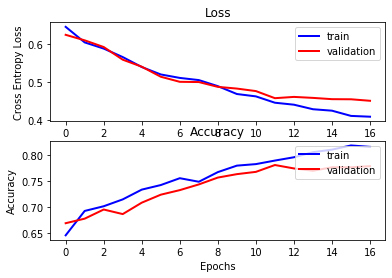

========= Eperiment -  SimpleRNN + w2v_skipgram  =========


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-431
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1336
           1       0.74      0.63      0.68       604

    accuracy                           0.82      1940
   macro avg       0.79      0.77      0.78      1940
weighted avg       0.81      0.82      0.81      1940

Predicted     0    1
Actual              
0          1204  132
1           222  382


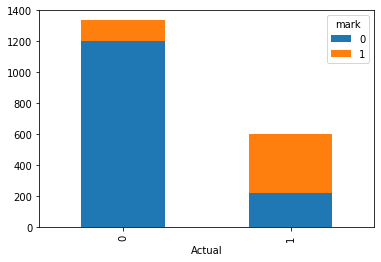

In [30]:
PARAMS = {'epoch': EPOCHS,
          'lr': 0.0001,
          'batch':BATCH_SIZE,
          'stemmed':False,
          'embedding':'word2vec_skipgram',
          'emb_trainable':False
          }
RNN_model,prediction = train_model(model,X_train,X_test,Y_train,Y_test,"SimpleRNN + w2v_skipgram")

In [31]:
arr_index=X_te.index
arr_index

Int64Index([1119, 5601, 5175,  857,  846, 6090, 2797, 4238, 4093,  485,
            ...
            6037, 3091, 1116, 1446, 1656, 2032, 3927, 1168, 2667, 5567],
           dtype='int64', length=1940)

In [22]:
def res_map(x):
    if(x==0):
        return "Not Hate"
    if(x==1):
        return "Hate"

In [33]:
Results1.to_csv("Predictions_result/RNN_w2v_skipgram_1.csv",index=False)

In [32]:
i=0
Results1 = pd.DataFrame(columns=["org_index","comment","pred_label","label"])
for s in X_te:
    print(s)
    Results1.at[i,"org_index"] = arr_index[i]
    Results1.at[i,"comment"] = s
    Results1.at[i,'pred_label'] = prediction[i]
    Results1.at[i,'label'] = Y_test[arr_index[i]]
    print("Predicted Label : ",res_map(prediction[i])," | Turth Label : ",res_map(Y_test[arr_index[i]]))
    i+=1
    print()
Results1.head(n=10)

එන්න එන්න දැන් පරක්කු නෑ මුළ ටික හෙට එකෙන් අහමු ඊට පස්සේ ආයම
Predicted Label :  Not Hate  | Turth Label :  Not Hate

ඕකගේ ලාච්චුවේ දාපල්ලා නරුමයා
Predicted Label :  Hate  | Turth Label :  Hate

කන්න බොන්න දීලා කරට අත දාගෙන පිටිපස්සෙන් පිහියෙන් අනින සිස්ටම් එක තමයි පර්සි ලග තිබ්බෙ අන්තිමට පර්සි ලග හිටියා සුමනයා පර්සිටත් දුන්නෙ එවැනිම පාරක් තමයි හතර ගාතෙන් ඇදගෙන වැටෙන්න
Predicted Label :  Hate  | Turth Label :  Not Hate

කෝටි න් ගියත් ත්‍රී වීල් එකෙන් ගියත් යන්නෙ එකම පාරෙ නෙ බං කවදාහරි දවසක ඕකත් දිරලා වල පල්ලට යනවා කෝටි කින් කරන්න තව වැඩ කොච්චර නම් තියේද
Predicted Label :  Not Hate  | Turth Label :  Hate

ඒකි හිතන් ඇත්තේ අපිට පුපේ ඉත්තෑවෝ දුවනව කියලද දන්නෑ ෆේක් වලින් හරි ගිහින් එව්ව බලන්න
Predicted Label :  Not Hate  | Turth Label :  Hate

මේ තට්ටයව මුණ ගැහිලම විස්තරේ අහගනින් සියනෑවේ සිංහයා කියලා ඡන්දෙට ඉල්ලුවෙ සිංහයෙක් තියා හිවලෙක්වත් වෙන්න බෑ කියලා දැන් ඔප්පු වෙලා තියෙන්නෙ
Predicted Label :  Not Hate  | Turth Label :  Hate

සිවුරක් දමාගැනීම දමිත් අසංක පුක පෙන්වීම පිදුරංගල වීරයෝ සෙට් එක

,org_index,comment,pred_label,label
0,1119,එන්න එන්න දැන් පරක්කු නෑ මුළ ටික හෙට එකෙන් අහමු ඊට පස්සේ ආයම,0,0
1,5601,ඕකගේ ලාච්චුවේ දාපල්ලා නරුමයා,1,1
2,5175,කන්න බොන්න දීලා කරට අත දාගෙන පිටිපස්සෙන් පිහියෙන් අනින සිස්ටම් එක තමයි පර්සි ලග තිබ්බෙ අන්තිමට පර්සි ලග හිටියා සුමනයා පර්සිටත් දුන්නෙ එවැනිම පාරක් තමයි හතර ගාතෙන් ඇදගෙන වැටෙන්න,1,0
3,857,කෝටි න් ගියත් ත්‍රී වීල් එකෙන් ගියත් යන්නෙ එකම පාරෙ නෙ බං කවදාහරි දවසක ඕකත් දිරලා වල පල්ලට යනවා කෝටි කින් කරන්න තව වැඩ කොච්චර නම් තියේද,0,1
4,846,ඒකි හිතන් ඇත්තේ අපිට පුපේ ඉත්තෑවෝ දුවනව කියලද දන්නෑ ෆේක් වලින් හරි ගිහින් එව්ව බලන්න,0,1
5,6090,මේ තට්ටයව මුණ ගැහිලම විස්තරේ අහගනින් සියනෑවේ සිංහයා කියලා ඡන්දෙට ඉල්ලුවෙ සිංහයෙක් තියා හිවලෙක්වත් වෙන්න බෑ කියලා දැන් ඔප්පු වෙලා තියෙන්නෙ,0,1
6,2797,සිවුරක් දමාගැනීම දමිත් අසංක පුක පෙන්වීම පිදුරංගල වීරයෝ සෙට් එකම එකම සෙල් එකට සෙට් උනොත් සිංදු කිය කිය පුක පෙන්නතැකි,1,0
7,4238,උඹ දේශපාලන පලිගැනීම් ගැන දන්නෙම නැති තොත්ත බබා හොදම වැඩේ උඹට කවදාහරි කරෝල වෙලා විදවලාම මැරියං,1,1
8,4093,කෝ බං වන් ෂොට් වන් මම හිතුවෙ මිනිහා පස් හය දෙනෙකුට වඩාගෙන ගහයි කියලා,1,0
9,485,අනේ පලයන් බොල බොරු නොකියා නොදන්න මිනිහෙක් ඇවිල්ලා ප්‍රශ්න අහනකොට මේ වගේ උත්තර දෙනවද උන් මේවා කියපන් කොන්ඩෙ බැදපු චීනෙක්ට,1,1


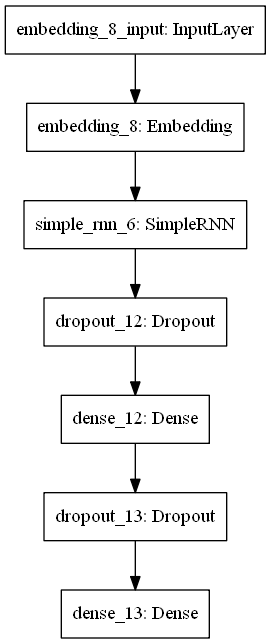

In [79]:
plot_model(RNN_model)

### Result and logging

In [29]:
def train_model(model,train_seq,test_seq,Y_train,Y_test,tag):
  
  #define callbacks
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1,mode='min',restore_best_weights=True)
  #callbacks_list = [early_stopping]

  #model training
  print("started training")
  hist = model.fit(train_seq, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping],validation_split=0.1, shuffle=False, verbose=2)
  train_loss, train_acc = model.evaluate(train_seq, Y_train,batch_size=BATCH_SIZE, verbose=1)
  print("train loss - ",train_loss," train acc- ",train_acc)
  test_loss, test_acc = model.evaluate(test_seq,Y_test,batch_size=BATCH_SIZE, verbose=1)
  print("test loss - ",test_loss," test acc- ",test_acc)

  # plot loss during training
  #from matplotlib import pyplot
  print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
  plt.subplot(211)
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel("Cross Entropy Loss")
  plt.plot(hist.history['loss'],lw=2.0, color='b', label='train')
  plt.plot(hist.history['val_loss'],lw=2.0, color='r', label='validation')
  plt.legend(loc='upper right')
  # plot accuracy during training
  plt.subplot(212)
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(hist.history['accuracy'],lw=2.0, color='b', label='train')
  plt.plot(hist.history['val_accuracy'],lw=2.0, color='r', label='validation')
  plt.legend(loc='upper right')
  plt.show()
  #(model.predict(x) > 0.5).astype("int32")
  #np.where(y_pred > threshold, 1,0)
  Y_pred =(model.predict(test_seq) > 0.5).astype("int32")# model.predict_class(test_seq)
  Y_pred = np.squeeze(Y_pred)
  log_result(Y_test,Y_pred,"w2v_skipgram","RNN",tag)
  print(classification_report(Y_test,Y_pred))
  #Y_pred = np.squeeze(Y_pred)
  utills.confusion_Matrix(Y_test,Y_pred)
  utills.PlotRocAuc(Y_test,Y_pred,'blue',"RNN")
  return model,Y_pred

In [24]:
def log_result(Y_test,Y_pred,feature_name,model_name,tag):
    print("========= Eperiment - ",tag," =========")
    neptune.create_experiment(tag,params=PARAMS)
    neptune.append_tag(['DL experiment',feature_name,model_name,tag])
    
    log_class_metrics(Y_test, Y_pred)
    log_confusion_matrix(Y_test, Y_pred)
    log_classification_report(Y_test, Y_pred)

In [33]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)